In [146]:
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.neighbors import NearestNeighbors
from sklearn.cluster import AgglomerativeClustering
from sklearn import preprocessing
import seaborn as sns
import matplotlib.pyplot as plt
import os

"Overall Stats" is the dataset Stephen scraped, "Defense Stats" is the dataset Richard Scraped

In [2]:
overall_stats_raw = pd.read_csv("FinalGameLogs.csv")
defense_stats_raw = pd.read_csv("defense_1920.csv")

4/12 Modification to use data from all seasons for more consistent comparisons

In [29]:
defense_files = [pd.read_csv(filename) for filename in os.listdir() if filename.startswith('defense_')]
defense_frame = pd.concat(defense_files)
defense_frame.shape
defense_stats_raw = defense_frame

Coerce the right datatypes for a few of the fields

In [30]:
defense_stats = defense_stats_raw.assign(PLAYER_ID = lambda df: df.PLAYER_ID.astype(int).astype(str),
                                         TEAM_ID = lambda df: df.TEAM_ID.astype(int).astype(str),
                                         #Game_Date = lambda df: pd.to_datetime(df.date).dt.date,
                                         Game_Date = lambda df: df.date)
defense_stats.shape

(149738, 166)

Get the aggregate counts of defense shot types by player

In [31]:
numeric_defense_stats_aggs = (defense_stats
                         .set_index('PLAYER_ID')
                        # use only the numeric columns
                         .select_dtypes(include=['float64', 'int64'])
                        # remove the duplicate columns that were returned by multiple APIs
                         .drop(['AGE_x', 'GP_x', 'W_x', 'L_x', 'MIN_x', 'DREB_x'], axis='columns')
                         .groupby('PLAYER_ID')
                         .agg(sum))

Fix percentages and averages, which are no longer accurate after summation

In [32]:
numeric_defense_stats = (numeric_defense_stats_aggs
                         .rename({
                             'AGE_y': 'AGE',
                             'GP_y': 'GP',
                             'W_y': 'W',
                             'L_y': 'L',
                             'DREB_y': 'DREB',
                             'MIN_y': 'MIN'
                         }, axis='columns')
                         .assign(
                        OPP_FG_PCT_LESS5 = lambda df: df.OPP_FGM_LESS5 / df.OPP_FGA_LESS5,
                        OPP_FG_PCT_5_9 = lambda df: df.OPP_FGM_5_9 / df.OPP_FGA_5_9,
                        OPP_FG_PCT_10_14 = lambda df: df.OPP_FGM_10_14 / df.OPP_FGA_10_14,
                        OPP_FG_PCT_15_19 = lambda df: df.OPP_FGM_15_19 / df.OPP_FGA_15_19,
                        OPP_FG_PCT_20_24 = lambda df: df.OPP_FGM_20_24 / df.OPP_FGA_20_24,
                        OPP_FG_PCT_25_29 = lambda df: df.OPP_FGM_25_29 / df.OPP_FGA_25_29,
                        OPP_FG_PCT_30_34 = lambda df: df.OPP_FGM_30_34 / df.OPP_FGA_30_34,
                        OPP_FG_PCT_35_39 = lambda df: df.OPP_FGM_35_39 / df.OPP_FGA_35_39,
                        OPP_FG_PCT_40PLUS = lambda df: df.OPP_FGM_40PLUS / df.OPP_FGA_40PLUS,
                        OPP_FG_PCT_LESS5_PACE_ADJ = lambda df: df.OPP_FGM_LESS5_PACE_ADJ / df.OPP_FGA_LESS5_PACE_ADJ,
                        OPP_FG_PCT_5_9_PACE_ADJ = lambda df: df.OPP_FGM_5_9_PACE_ADJ / df.OPP_FGA_5_9_PACE_ADJ,
                        OPP_FG_PCT_10_14_PACE_ADJ = lambda df: df.OPP_FGM_10_14_PACE_ADJ / df.OPP_FGA_10_14_PACE_ADJ,
                        OPP_FG_PCT_15_19_PACE_ADJ = lambda df: df.OPP_FGM_15_19_PACE_ADJ / df.OPP_FGA_15_19_PACE_ADJ,
                        OPP_FG_PCT_20_24_PACE_ADJ = lambda df: df.OPP_FGM_20_24_PACE_ADJ / df.OPP_FGA_20_24_PACE_ADJ,
                        OPP_FG_PCT_25_29_PACE_ADJ = lambda df: df.OPP_FGM_25_29_PACE_ADJ / df.OPP_FGA_25_29_PACE_ADJ,
                        OPP_FG_PCT_30_34_PACE_ADJ = lambda df: df.OPP_FGM_30_34_PACE_ADJ / df.OPP_FGA_30_34_PACE_ADJ,
                        OPP_FG_PCT_35_39_PACE_ADJ = lambda df: df.OPP_FGM_35_39_PACE_ADJ / df.OPP_FGA_35_39_PACE_ADJ,
                        OPP_FG_PCT_40PLUS_PACE_ADJ = lambda df: df.OPP_FGM_40PLUS_PACE_ADJ / df.OPP_FGA_40PLUS_PACE_ADJ,
                        OREB_CONTEST_PCT = lambda df: df.OREB_CONTEST / df.OREB,
                        OREB_CHANCE_PCT = lambda df: df.OREB / df.OREB_CHANCES,
                        OREB_CHANCE_PCT_ADJ = lambda df: df.OREB_CHANCE_PCT_ADJ / df.GP,
                        AVG_OREB_DIST = lambda df: df.AVG_OREB_DIST / df.GP,
                        DREB_CONTEST_PCT = lambda df: df.DREB_CONTEST / df.DREB,
                        DREB_CHANCE_PCT = lambda df: df.DREB / df.DREB_CHANCES,
                        DREB_CHANCE_PCT_ADJ = lambda df: df.DREB_CHANCE_PCT_ADJ / df.GP,
                        AVG_DREB_DIST = lambda df: df.AVG_DREB_DIST / df.GP,
                        REB_CONTEST_PCT = lambda df: df.REB_CONTEST / df.REB,
                        REB_CHANCE_PCT = lambda df: df.REB / df.REB_CHANCES,
                        REB_CHANCE_PCT_ADJ = lambda df: df.REB_CHANCE_PCT_ADJ / df.GP,
                        AVG_REB_DIST = lambda df: df.AVG_REB_DIST / df.GP,
                        DEF_RIM_FG_PCT = lambda df: df.DEF_RIM_FGM / df.DEF_RIM_FGA,
                        PCT_LOOSE_BALLS_RECOVERED_OFF = lambda df: df.OFF_LOOSE_BALLS_RECOVERED / df.LOOSE_BALLS_RECOVERED,
                        PCT_LOOSE_BALLS_RECOVERED_DEF = lambda df: df.DEF_LOOSE_BALLS_RECOVERED / df.LOOSE_BALLS_RECOVERED,
                        PCT_BOX_OUTS_OFF = lambda df: df.OFF_BOXOUTS / df.BOX_OUTS,
                        PCT_BOX_OUTS_DEF = lambda df: df.DEF_BOXOUTS / df.BOX_OUTS,
                        OPP_FG_PCT_RES_AREA = lambda df: df.OPP_FGM_RES_AREA / df.OPP_FGA_RES_AREA,
                        OPP_FG_PCT_PAINT = lambda df: df.OPP_FGM_PAINT / df.OPP_FGA_PAINT,
                        OPP_FG_PCT_MID = lambda df: df.OPP_FGM_MID / df.OPP_FGA_MID,
                        OPP_FG_PCT_LEFT_CORNER = lambda df: df.OPP_FGM_LEFT_CORNER / df.OPP_FGA_LEFT_CORNER,
                        OPP_FG_PCT_RIGHT_CORNER = lambda df: df.OPP_FGM_RIGHT_CORNER / df.OPP_FGA_RIGHT_CORNER,
                        OPP_FG_PCT_ABOVE_BREAK = lambda df: df.OPP_FGM_ABOVE_BREAK / df.OPP_FGA_ABOVE_BREAK,
                        OPP_FG_PCT_BACKCOURT = lambda df: df.OPP_FGM_BACKCOURT / df.OPP_FGA_BACKCOURT,
                        OPP_FG_PCT_RES_AREA_PACE_ADJ = lambda df: df.OPP_FGM_RES_AREA_PACE_ADJ / df.OPP_FGA_RES_AREA_PACE_ADJ,
                        OPP_FG_PCT_PAINT_PACE_ADJ = lambda df: df.OPP_FGM_PAINT_PACE_ADJ / df.OPP_FGA_PAINT_PACE_ADJ,
                        OPP_FG_PCT_MID_PACE_ADJ = lambda df: df.OPP_FGM_MID_PACE_ADJ / df.OPP_FGA_MID_PACE_ADJ,
                        OPP_FG_PCT_LEFT_CORNER_PACE_ADJ = lambda df: df.OPP_FGM_LEFT_CORNER_PACE_ADJ / df.OPP_FGA_LEFT_CORNER_PACE_ADJ,
                        OPP_FG_PCT_RIGHT_CORNER_PACE_ADJ = lambda df: df.OPP_FGM_RIGHT_CORNER_PACE_ADJ / df.OPP_FGA_RIGHT_CORNER_PACE_ADJ,
                        OPP_FG_PCT_ABOVE_BREAK_PACE_ADJ = lambda df: df.OPP_FGM_ABOVE_BREAK_PACE_ADJ / df.OPP_FGA_ABOVE_BREAK_PACE_ADJ,
                        OPP_FG_PCT_BACKCOURT_PACE_ADJ = lambda df: df.OPP_FGM_BACKCOURT_PACE_ADJ / df.OPP_FGA_BACKCOURT_PACE_ADJ
                        )
                         .fillna(0)
                         # replace the occurrences where there was a rebound without a rebound chance
                         .replace(np.inf, 0)
                        )
numeric_defense_stats.head()

,OPP_FGM_LESS5,OPP_FGA_LESS5,OPP_FG_PCT_LESS5,OPP_FGM_5_9,OPP_FGA_5_9,OPP_FG_PCT_5_9,OPP_FGM_10_14,OPP_FGA_10_14,OPP_FG_PCT_10_14,OPP_FGM_15_19,...,OPP_FG_PCT_LEFT_CORNER_PACE_ADJ,OPP_FGM_RIGHT_CORNER_PACE_ADJ,OPP_FGA_RIGHT_CORNER_PACE_ADJ,OPP_FG_PCT_RIGHT_CORNER_PACE_ADJ,OPP_FGM_ABOVE_BREAK_PACE_ADJ,OPP_FGA_ABOVE_BREAK_PACE_ADJ,OPP_FG_PCT_ABOVE_BREAK_PACE_ADJ,OPP_FGM_BACKCOURT_PACE_ADJ,OPP_FGA_BACKCOURT_PACE_ADJ,OPP_FG_PCT_BACKCOURT_PACE_ADJ
PLAYER_ID,,,,,,,,,,,,,,,,,,,,,
101106,1488.0,2757.0,0.539717,410.0,1079.0,0.379981,425.0,1010.0,0.420792,672.0,...,0.412000,105.0,249.0,0.421687,569.0,1730.0,0.328902,0.0,9.0,0.000000
101107,4090.0,6790.0,0.602356,759.0,1964.0,0.386456,679.0,1581.0,0.429475,1101.0,...,0.403026,311.0,708.0,0.439266,1675.0,4809.0,0.348305,0.0,36.0,0.000000
101108,4743.0,7947.0,0.596829,996.0,2474.0,0.402587,769.0,2007.0,0.383159,1040.0,...,0.376682,308.0,826.0,0.372881,1852.0,5324.0,0.347859,0.0,56.0,0.000000
101109,2211.0,3730.0,0.592761,375.0,1015.0,0.369458,337.0,801.0,0.420724,501.0,...,0.345972,160.0,441.0,0.362812,869.0,2478.0,0.350686,1.0,23.0,0.043478
101110,788.0,1315.0,0.599240,191.0,449.0,0.425390,136.0,359.0,0.378830,259.0,...,0.465753,51.0,118.0,0.432203,317.0,860.0,0.368605,1.0,14.0,0.071429


Get numbers from the overall dataset that were not included in the defense-specific dataset

In [33]:
overall_stats_pre_index = (overall_stats_raw
                           .query("Season == '2019-20'")
                           [['idPlayer', 'isB2BFirst', 'isB2BSecond', 'countDaysRestTeam', 'countDaysNextGameTeam', 'numberGamePlayerSeason', 'countDaysRestPlayer', 'countDaysNextGamePlayer', 'isWin', 'minutes', 'ast', 'stl', 'blk', 'tov', 'pf', 'plusminus']]
                           .drop_duplicates()
                           .assign(PLAYER_ID = lambda df: df.idPlayer.astype(str))
                           .drop('idPlayer', axis='columns')
                           #.groupby(['idPlayer'])
                           .groupby('PLAYER_ID')
                           .agg({
                               'isB2BFirst': sum,
                               'isB2BSecond': sum,
                               'countDaysRestPlayer': 'mean',
                               'countDaysNextGamePlayer': 'mean',
                               'numberGamePlayerSeason': 'max',
                               'isWin': sum,
                               'minutes': sum,
                               'ast': sum, 'stl': sum, 'blk': sum, 'tov': sum, 'pf': sum, 'plusminus': [sum, 'min', 'max']
                           })
                           .reset_index())
#overall_stats.columns = overall_stats.columns.droplevel(0)
#overall_stats = overall_stats.rename_axis(None, axis=1)
overall_stats_pre_index.columns = ["_".join(pair) for pair in overall_stats_pre_index.columns]
overall_stats = (overall_stats_pre_index
                 .rename({'PLAYER_ID_': 'PLAYER_ID'}, axis='columns')
                 .set_index('PLAYER_ID'))
overall_stats.head(5)

,isB2BFirst_sum,isB2BSecond_sum,countDaysRestPlayer_mean,countDaysNextGamePlayer_mean,numberGamePlayerSeason_max,isWin_sum,minutes_sum,ast_sum,stl_sum,blk_sum,tov_sum,pf_sum,plusminus_sum,plusminus_min,plusminus_max
PLAYER_ID,,,,,,,,,,,,,,,
101107,10.0,10.0,4.080000,4.080000,50,20.0,966,52,35,25,28,86,-106,-25,23
101108,10.0,10.0,3.163934,3.163934,61,38.0,1934,407,94,8,132,136,277,-18,21
101133,5.0,5.0,4.421053,4.486486,38,15.0,806,49,31,44,45,114,-79,-23,18
101139,1.0,0.0,13.300000,14.666667,10,4.0,159,12,10,4,4,14,-8,-14,16
101141,8.0,8.0,3.648148,3.722222,54,45.0,863,46,22,14,31,86,123,-18,37


Combine the two datasets

In [34]:
combined_stats = (numeric_defense_stats
                  .merge(overall_stats,
                         how='outer',
                         left_index = True,
                         right_index = True)
                  .fillna(0))

Shortcut cell for saving & loading data manipulation up to this point

In [35]:
#combined_stats.to_pickle("combined_stats.pkl")
#combined_stats = pd.read_pickle("combined_stats.pkl")

Scale and center the dataset and perform PCA, checking out how much variance is explained by each component

In [36]:
scaled_defensive_stats = preprocessing.scale(combined_stats)
pca = PCA(n_components=50)
pca_scaled_defense = pca.fit_transform(scaled_defensive_stats)
pca.explained_variance_ratio_

array([0.53320016, 0.05800215, 0.05086103, 0.03403607, 0.02819633,
       0.02634482, 0.02380508, 0.01892552, 0.01709732, 0.0158033 ,
       0.01518189, 0.01320706, 0.01175867, 0.01102031, 0.01005784,
       0.00917088, 0.00881212, 0.00806172, 0.00738968, 0.00682574,
       0.00655307, 0.006132  , 0.00572451, 0.00465797, 0.00461224,
       0.00428858, 0.00417907, 0.00394148, 0.00342578, 0.00330397,
       0.00313971, 0.00296464, 0.00282567, 0.00272273, 0.00264869,
       0.0022043 , 0.0021388 , 0.00194854, 0.00182076, 0.00154951,
       0.00146453, 0.00139419, 0.00135597, 0.00127363, 0.00119825,
       0.0010147 , 0.00088815, 0.00084474, 0.0008075 , 0.00078017])

Perform t-SNE and check out what the overall plot looks like

In [37]:
raw_tsne = TSNE(n_components=2, perplexity=20, n_iter = 50000).fit_transform(pca_scaled_defense)
tsne_pd = pd.DataFrame(raw_tsne, columns = ['x', 'y'])

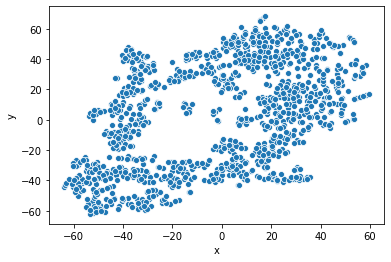

In [38]:
sns.scatterplot(x='x', y='y', data = tsne_pd)

In [39]:
combined_with_tsne = combined_stats.reset_index().merge(tsne_pd, how ='left', left_index=True, right_index=True)
combined_with_tsne#.to_csv("combined_with_tsne.csv", index=False)

,PLAYER_ID,OPP_FGM_LESS5,OPP_FGA_LESS5,OPP_FG_PCT_LESS5,OPP_FGM_5_9,OPP_FGA_5_9,OPP_FG_PCT_5_9,OPP_FGM_10_14,OPP_FGA_10_14,OPP_FG_PCT_10_14,...,ast_sum,stl_sum,blk_sum,tov_sum,pf_sum,plusminus_sum,plusminus_min,plusminus_max,x,y
0,101106,1488.0,2757.0,0.539717,410.0,1079.0,0.379981,425.0,1010.0,0.420792,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-44.741867,10.707431
1,101107,4090.0,6790.0,0.602356,759.0,1964.0,0.386456,679.0,1581.0,0.429475,...,52.0,35.0,25.0,28.0,86.0,-106.0,-25.0,23.0,-51.964870,-47.374699
2,101108,4743.0,7947.0,0.596829,996.0,2474.0,0.402587,769.0,2007.0,0.383159,...,407.0,94.0,8.0,132.0,136.0,277.0,-18.0,21.0,-56.646748,-41.960041
3,101109,2211.0,3730.0,0.592761,375.0,1015.0,0.369458,337.0,801.0,0.420724,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-37.987923,-6.618549
4,101110,788.0,1315.0,0.599240,191.0,449.0,0.425390,136.0,359.0,0.378830,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-31.397099,33.818111
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1069,951,651.0,1091.0,0.596700,146.0,317.0,0.460568,82.0,203.0,0.403941,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-5.769437,31.706974
1070,959,126.0,211.0,0.597156,18.0,57.0,0.315789,22.0,49.0,0.448980,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-3.077466,25.678610
1071,965,453.0,810.0,0.559259,86.0,233.0,0.369099,77.0,180.0,0.427778,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-30.116510,42.000488
1072,977,1412.0,2237.0,0.631203,213.0,504.0,0.422619,193.0,464.0,0.415948,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-17.486668,32.123978


### Per 36

Let's see how things shift when we adjust the raw counts to a per-36 minute basis.

In [40]:
combined_per36 = (combined_stats
                  .assign(per36_factor = lambda df: 36.0 / df.MIN,
                          OPP_FGM_LESS5 = lambda df: df.OPP_FGM_LESS5 * df.per36_factor,
                          OPP_FGA_LESS5 = lambda df: df.OPP_FGA_LESS5 * df.per36_factor,
                          OPP_FGM_5_9 = lambda df: df.OPP_FGM_5_9 * df.per36_factor,
                          OPP_FGA_5_9 = lambda df: df.OPP_FGA_5_9 * df.per36_factor,
                          OPP_FGM_10_14 = lambda df: df.OPP_FGM_10_14 * df.per36_factor,
                          OPP_FGA_10_14 = lambda df: df.OPP_FGA_10_14 * df.per36_factor,
                          OPP_FGM_15_19 = lambda df: df.OPP_FGM_15_19 * df.per36_factor,
                          OPP_FGA_15_19 = lambda df: df.OPP_FGA_15_19 * df.per36_factor,
                          OPP_FGM_20_24 = lambda df: df.OPP_FGM_20_24 * df.per36_factor,
                          OPP_FGA_20_24 = lambda df: df.OPP_FGA_20_24 * df.per36_factor,
                          OPP_FGM_25_29 = lambda df: df.OPP_FGM_25_29 * df.per36_factor,
                          OPP_FGA_25_29 = lambda df: df.OPP_FGA_25_29 * df.per36_factor,
                          OPP_FGM_30_34 = lambda df: df.OPP_FGM_30_34 * df.per36_factor,
                          OPP_FGA_30_34 = lambda df: df.OPP_FGA_30_34 * df.per36_factor,
                          OPP_FGM_35_39 = lambda df: df.OPP_FGM_35_39 * df.per36_factor,
                          OPP_FGA_35_39 = lambda df: df.OPP_FGA_35_39 * df.per36_factor,
                          OPP_FGM_40PLUS = lambda df: df.OPP_FGM_40PLUS * df.per36_factor,
                          OPP_FGA_40PLUS = lambda df: df.OPP_FGA_40PLUS * df.per36_factor,
                          OPP_FGM_LESS5_PACE_ADJ = lambda df: df.OPP_FGM_LESS5_PACE_ADJ * df.per36_factor,
                          OPP_FGA_LESS5_PACE_ADJ = lambda df: df.OPP_FGA_LESS5_PACE_ADJ * df.per36_factor,
                          OPP_FGM_5_9_PACE_ADJ = lambda df: df.OPP_FGM_5_9_PACE_ADJ * df.per36_factor,
                          OPP_FGA_5_9_PACE_ADJ = lambda df: df.OPP_FGA_5_9_PACE_ADJ * df.per36_factor,
                          OPP_FGM_10_14_PACE_ADJ = lambda df: df.OPP_FGM_10_14_PACE_ADJ * df.per36_factor,
                          OPP_FGA_10_14_PACE_ADJ = lambda df: df.OPP_FGA_10_14_PACE_ADJ * df.per36_factor,
                          OPP_FGM_15_19_PACE_ADJ = lambda df: df.OPP_FGM_15_19_PACE_ADJ * df.per36_factor,
                          OPP_FGA_15_19_PACE_ADJ = lambda df: df.OPP_FGA_15_19_PACE_ADJ * df.per36_factor,
                          OPP_FGM_20_24_PACE_ADJ = lambda df: df.OPP_FGM_20_24_PACE_ADJ * df.per36_factor,
                          OPP_FGA_20_24_PACE_ADJ = lambda df: df.OPP_FGA_20_24_PACE_ADJ * df.per36_factor,
                          OPP_FGM_25_29_PACE_ADJ = lambda df: df.OPP_FGM_25_29_PACE_ADJ * df.per36_factor,
                          OPP_FGA_25_29_PACE_ADJ = lambda df: df.OPP_FGA_25_29_PACE_ADJ * df.per36_factor,
                          OPP_FGM_30_34_PACE_ADJ = lambda df: df.OPP_FGM_30_34_PACE_ADJ * df.per36_factor,
                          OPP_FGA_30_34_PACE_ADJ = lambda df: df.OPP_FGA_30_34_PACE_ADJ * df.per36_factor,
                          OPP_FGM_35_39_PACE_ADJ = lambda df: df.OPP_FGM_35_39_PACE_ADJ * df.per36_factor,
                          OPP_FGA_35_39_PACE_ADJ = lambda df: df.OPP_FGA_35_39_PACE_ADJ * df.per36_factor,
                          OPP_FGM_40PLUS_PACE_ADJ = lambda df: df.OPP_FGM_40PLUS_PACE_ADJ * df.per36_factor,
                          OPP_FGA_40PLUS_PACE_ADJ = lambda df: df.OPP_FGA_40PLUS_PACE_ADJ * df.per36_factor,
                          OREB = lambda df: df.OREB * df.per36_factor,
                          OREB_CONTEST = lambda df: df.OREB_CONTEST * df.per36_factor,
                          OREB_UNCONTEST = lambda df: df.OREB_UNCONTEST * df.per36_factor,
                          OREB_CHANCES = lambda df: df.OREB_CHANCES * df.per36_factor,
                          OREB_CHANCE_DEFER = lambda df: df.OREB_CHANCE_DEFER * df.per36_factor,
                          DREB_CONTEST = lambda df: df.DREB_CONTEST * df.per36_factor,
                          DREB_UNCONTEST = lambda df: df.DREB_UNCONTEST * df.per36_factor,
                          DREB_CHANCES = lambda df: df.DREB_CHANCES * df.per36_factor,
                          DREB_CHANCE_DEFER = lambda df: df.DREB_CHANCE_DEFER * df.per36_factor,
                          REB = lambda df: df.REB * df.per36_factor,
                          REB_CONTEST = lambda df: df.REB_CONTEST * df.per36_factor,
                          REB_UNCONTEST = lambda df: df.REB_UNCONTEST * df.per36_factor,
                          REB_CHANCES = lambda df: df.REB_CHANCES * df.per36_factor,
                          REB_CHANCE_DEFER = lambda df: df.REB_CHANCE_DEFER * df.per36_factor,
                          AVG_REB_DIST = lambda df: df.AVG_REB_DIST * df.per36_factor,
                          STL = lambda df: df.STL * df.per36_factor,
                          BLK = lambda df: df.BLK * df.per36_factor,
                          DREB = lambda df: df.DREB * df.per36_factor,
                          DEF_RIM_FGM = lambda df: df.DEF_RIM_FGM * df.per36_factor,
                          DEF_RIM_FGA = lambda df: df.DEF_RIM_FGA * df.per36_factor,
                          CONTESTED_SHOTS = lambda df: df.CONTESTED_SHOTS * df.per36_factor,
                          CONTESTED_SHOTS_2PT = lambda df: df.CONTESTED_SHOTS_2PT * df.per36_factor,
                          CONTESTED_SHOTS_3PT = lambda df: df.CONTESTED_SHOTS_3PT * df.per36_factor,
                          DEFLECTIONS = lambda df: df.DEFLECTIONS * df.per36_factor,
                          CHARGES_DRAWN = lambda df: df.CHARGES_DRAWN * df.per36_factor,
                          SCREEN_ASSISTS = lambda df: df.SCREEN_ASSISTS * df.per36_factor,
                          SCREEN_AST_PTS = lambda df: df.SCREEN_AST_PTS * df.per36_factor,
                          OFF_LOOSE_BALLS_RECOVERED = lambda df: df.OFF_LOOSE_BALLS_RECOVERED * df.per36_factor,
                          DEF_LOOSE_BALLS_RECOVERED = lambda df: df.DEF_LOOSE_BALLS_RECOVERED * df.per36_factor,
                          LOOSE_BALLS_RECOVERED = lambda df: df.LOOSE_BALLS_RECOVERED * df.per36_factor,
                          OFF_BOXOUTS = lambda df: df.OFF_BOXOUTS * df.per36_factor,
                          DEF_BOXOUTS = lambda df: df.DEF_BOXOUTS * df.per36_factor,
                          BOX_OUTS = lambda df: df.BOX_OUTS * df.per36_factor,
                          BOX_OUT_PLAYER_TEAM_REBS = lambda df: df.BOX_OUT_PLAYER_TEAM_REBS * df.per36_factor,
                          BOX_OUT_PLAYER_REBS = lambda df: df.BOX_OUT_PLAYER_REBS * df.per36_factor,
                          OPP_FGM_RES_AREA = lambda df: df.OPP_FGM_RES_AREA * df.per36_factor,
                          OPP_FGA_RES_AREA = lambda df: df.OPP_FGA_RES_AREA * df.per36_factor,
                          OPP_FGM_PAINT = lambda df: df.OPP_FGM_PAINT * df.per36_factor,
                          OPP_FGA_PAINT = lambda df: df.OPP_FGA_PAINT * df.per36_factor,
                          OPP_FGM_MID = lambda df: df.OPP_FGM_MID * df.per36_factor,
                          OPP_FGA_MID = lambda df: df.OPP_FGA_MID * df.per36_factor,
                          OPP_FG_PCT_MID = lambda df: df.OPP_FG_PCT_MID * df.per36_factor,
                          OPP_FGM_LEFT_CORNER = lambda df: df.OPP_FGM_LEFT_CORNER * df.per36_factor,
                          OPP_FGA_LEFT_CORNER = lambda df: df.OPP_FGA_LEFT_CORNER * df.per36_factor,
                          OPP_FGM_RIGHT_CORNER = lambda df: df.OPP_FGM_RIGHT_CORNER * df.per36_factor,
                          OPP_FGA_RIGHT_CORNER = lambda df: df.OPP_FGA_RIGHT_CORNER * df.per36_factor,
                          OPP_FGM_ABOVE_BREAK = lambda df: df.OPP_FGM_ABOVE_BREAK * df.per36_factor,
                          OPP_FGA_ABOVE_BREAK = lambda df: df.OPP_FGA_ABOVE_BREAK * df.per36_factor,
                          OPP_FGM_BACKCOURT = lambda df: df.OPP_FGM_BACKCOURT * df.per36_factor,
                          OPP_FGA_BACKCOURT = lambda df: df.OPP_FGA_BACKCOURT * df.per36_factor,
                          OPP_FGM_RES_AREA_PACE_ADJ = lambda df: df.OPP_FGM_RES_AREA_PACE_ADJ * df.per36_factor,
                          OPP_FGA_RES_AREA_PACE_ADJ = lambda df: df.OPP_FGA_RES_AREA_PACE_ADJ * df.per36_factor,
                          OPP_FGM_PAINT_PACE_ADJ = lambda df: df.OPP_FGM_PAINT_PACE_ADJ * df.per36_factor,
                          OPP_FGA_PAINT_PACE_ADJ = lambda df: df.OPP_FGA_PAINT_PACE_ADJ * df.per36_factor,
                          OPP_FGM_MID_PACE_ADJ = lambda df: df.OPP_FGM_MID_PACE_ADJ * df.per36_factor,
                          OPP_FGA_MID_PACE_ADJ = lambda df: df.OPP_FGA_MID_PACE_ADJ * df.per36_factor,
                          OPP_FGM_LEFT_CORNER_PACE_ADJ = lambda df: df.OPP_FGM_LEFT_CORNER_PACE_ADJ * df.per36_factor,
                          OPP_FGA_LEFT_CORNER_PACE_ADJ = lambda df: df.OPP_FGA_LEFT_CORNER_PACE_ADJ * df.per36_factor,
                          OPP_FGM_RIGHT_CORNER_PACE_ADJ = lambda df: df.OPP_FGM_RIGHT_CORNER_PACE_ADJ * df.per36_factor,
                          OPP_FGA_RIGHT_CORNER_PACE_ADJ = lambda df: df.OPP_FGA_RIGHT_CORNER_PACE_ADJ * df.per36_factor,
                          OPP_FGM_ABOVE_BREAK_PACE_ADJ = lambda df: df.OPP_FGM_ABOVE_BREAK_PACE_ADJ * df.per36_factor,
                          OPP_FGA_ABOVE_BREAK_PACE_ADJ = lambda df: df.OPP_FGA_ABOVE_BREAK_PACE_ADJ * df.per36_factor,
                          OPP_FGM_BACKCOURT_PACE_ADJ = lambda df: df.OPP_FGM_BACKCOURT_PACE_ADJ * df.per36_factor,
                          OPP_FGA_BACKCOURT_PACE_ADJ = lambda df: df.OPP_FGA_BACKCOURT_PACE_ADJ * df.per36_factor,
                          ast_sum = lambda df: df.ast_sum * df.per36_factor,
                          stl_sum = lambda df: df.stl_sum * df.per36_factor,
                          blk_sum = lambda df: df.blk_sum * df.per36_factor,
                          tov_sum = lambda df: df.tov_sum * df.per36_factor,
                          pf_sum = lambda df: df.pf_sum * df.per36_factor,
                          plusminus_sum = lambda df: df.plusminus_sum * df.per36_factor
                         ))

combined_per36.head(5)

,OPP_FGM_LESS5,OPP_FGA_LESS5,OPP_FG_PCT_LESS5,OPP_FGM_5_9,OPP_FGA_5_9,OPP_FG_PCT_5_9,OPP_FGM_10_14,OPP_FGA_10_14,OPP_FG_PCT_10_14,OPP_FGM_15_19,...,minutes_sum,ast_sum,stl_sum,blk_sum,tov_sum,pf_sum,plusminus_sum,plusminus_min,plusminus_max,per36_factor
PLAYER_ID,,,,,,,,,,,,,,,,,,,,,
101106,10.438646,19.340959,0.539717,2.876240,7.569421,0.379981,2.981468,7.085371,0.420792,4.714227,...,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.007015
101107,13.180085,21.880874,0.602356,2.445889,6.329019,0.386456,2.188087,5.094796,0.429475,3.547989,...,966.0,0.167571,0.112788,0.080563,0.090230,0.277136,-0.341587,-25.0,23.0,0.003223
101108,12.975758,21.741166,0.596829,2.724827,6.768295,0.402587,2.103807,5.490691,0.383159,2.845201,...,1934.0,1.113458,0.257162,0.021886,0.361122,0.372065,0.757808,-18.0,21.0,0.002736
101109,12.823999,21.634337,0.592761,2.175034,5.887092,0.369458,1.954630,4.645872,0.420724,2.905845,...,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.005800
101110,11.444709,19.098721,0.599240,2.774035,6.521160,0.425390,1.975229,5.214023,0.378830,3.761649,...,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.014524


In [41]:
scaled_per36 = preprocessing.scale(combined_per36)
pca_per36 = PCA(n_components=50)
pca_scaled_per36 = pca_per36.fit_transform(scaled_per36)
pca_per36.explained_variance_ratio_

array([0.11162024, 0.0913862 , 0.07683562, 0.06455147, 0.04624288,
       0.04416076, 0.03746645, 0.03289114, 0.02954936, 0.02657063,
       0.0253791 , 0.02250448, 0.02117909, 0.01984407, 0.01869613,
       0.01844544, 0.01724768, 0.01513936, 0.01463429, 0.01358315,
       0.01285663, 0.01219152, 0.01133477, 0.01106436, 0.01024257,
       0.00944162, 0.00917732, 0.00864021, 0.00841334, 0.00803031,
       0.00776566, 0.00755211, 0.00695685, 0.00634687, 0.00624966,
       0.00584164, 0.0056115 , 0.00542276, 0.00511238, 0.00492392,
       0.00466741, 0.00441113, 0.00387833, 0.00376802, 0.00372504,
       0.00355121, 0.00339525, 0.00335824, 0.00319993, 0.00303842])

In [105]:
current_season_player_id_ints = list(overall_stats_raw[overall_stats_raw['Season'] == '2019-20']['idPlayer'].drop_duplicates())
current_season_player_ids = [str(i) for i in current_season_player_id_ints]
current_season_filter = combined_stats.index.isin(current_season_player_ids)
pca_scaled_per36[current_season_filter].shape

(513, 50)

In [212]:
clustering = AgglomerativeClustering(n_clusters=4).fit(pca_scaled_per36[current_season_filter])

In [215]:
#pd.Series(clustering.labels_).value_counts()
pca_with_cluster_col = (pd.DataFrame(pca_scaled_per36[current_season_filter]).assign(label = clustering.labels_))
pca_with_clusters = pd.get_dummies(pca_with_cluster, columns = ['label'])
pca_with_clusters

,0,1,2,3,4,5,6,7,8,9,...,44,45,46,47,48,49,label_0,label_1,label_2,label_3
0,-1.732806,-4.432393,-3.312895,-2.078466,0.712733,2.686622,-1.374034,-0.083844,0.275254,0.921112,...,0.354041,0.455630,-0.078685,-0.051106,0.443275,-0.217782,0,0,0,1
1,-1.025242,-2.671325,-5.285929,-0.807114,2.395147,2.581663,-2.059474,-0.316633,-0.432966,0.687488,...,-0.379393,-0.030662,-0.334001,0.299315,0.208225,-0.299264,0,0,0,1
2,-1.433728,-5.447619,0.839846,-2.870298,0.080352,1.340002,-0.572997,0.094992,0.691592,0.538928,...,0.381704,0.284278,-0.078558,-0.100513,0.415155,-0.031555,0,0,0,1
3,2.315475,-0.871184,-2.459420,0.082097,2.154959,0.856778,-0.445197,-0.378806,0.350073,1.184902,...,0.497243,0.379456,-0.359666,-0.083826,-0.141167,-0.214073,0,0,0,1
4,-2.339053,-5.118803,-1.873009,-2.378879,0.742301,1.911395,-0.496743,0.271966,0.382861,1.516164,...,-0.519038,0.161382,0.845029,-0.094588,-0.089652,-0.753266,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
508,0.763735,-2.074575,-4.433156,-1.371266,2.356408,3.082969,-0.869140,-0.084369,-0.147798,0.652729,...,-0.097932,-0.437199,-0.477773,-0.093703,0.374388,-0.341776,0,0,0,1
509,2.439752,-1.495681,2.066335,-0.951327,0.367649,-0.055943,2.286970,1.211639,-0.370337,0.105890,...,1.898367,0.087077,-0.573517,0.595708,-1.342535,0.059871,0,1,0,0
510,-2.893256,-8.115828,0.573126,-3.273391,-0.844138,1.910438,-1.981591,0.928974,0.216054,-0.275514,...,-0.286811,-0.361497,1.058547,0.988893,-0.865434,-0.082279,0,0,0,1
511,0.437726,-3.252705,-3.470169,-0.026308,2.818107,0.884429,-0.955022,0.274239,0.389750,0.305186,...,-0.104861,-0.031635,-0.110379,0.246069,0.472035,-0.009288,0,0,0,1


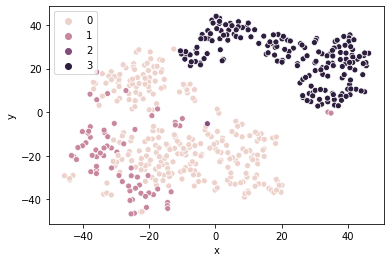

In [221]:
# tsne_per36 = TSNE(n_components=2, perplexity=15, n_iter = 40000).fit_transform(pca_scaled_per36[current_season_filter])
tsne_per36 = TSNE(n_components=2, perplexity=15, n_iter = 40000).fit_transform(pca_with_clusters)
tsne_per36_df = pd.DataFrame(tsne_per36, columns = ['x', 'y'])
sns.scatterplot(x='x', y='y', hue = clustering.labels_, data = tsne_per36_df)

In [224]:
combined_with_per36_tsne = (combined_stats[current_season_filter]
                            .reset_index()
                            .merge(tsne_per36_df, 
                                   how ='left', 
                                   left_index=True, 
                                   right_index=True)
                            .assign(cluster_label = clustering.labels_))
combined_with_per36_tsne.to_csv("combined_with_per36_tsne_with_additional_seasons.csv", index=False)

Nearest Neighbors

In [115]:
neigh = NearestNeighbors()
neigh.fit(pca_scaled_per36[current_season_filter])
neigh_graph = neigh.kneighbors_graph(pca_scaled_per36[current_season_filter]).toarray()
distances, indices = neigh.kneighbors(pca_scaled_per36[current_season_filter])
indices[:10]

array([[  0, 395, 394, 325, 429],
       [  1, 360, 381, 385, 357],
       [  2, 430, 421, 440, 436],
       [  3, 352, 457, 400, 398],
       [  4,   0, 336, 444, 366],
       [  5, 441, 403, 415, 423],
       [  6,  14, 448,  26,  44],
       [  7, 500,  19, 471, 328],
       [  8, 133,  46,  80,  99],
       [  9,  15, 449, 501, 129]])

In [183]:
mm_scaler = preprocessing.MinMaxScaler()

zipped_sample = zip(indices, distances, clustering.labels_)
player_comp_list = []

for z in zipped_sample:
    i, d, clus = z
    root_player_id = int(combined_stats[current_season_filter].iloc[i[0]].name)
    try:
        root_player_name = overall_stats_raw[overall_stats_raw['idPlayer'] == root_player_id].iloc[0]['Player']
        for player in range(1, len(i)):
            comp_player_id = int(combined_stats[current_season_filter].iloc[i[player]].name)
            player_name = overall_stats_raw[overall_stats_raw['idPlayer'] == comp_player_id].iloc[0]['Player']
            new_row = [root_player_id, root_player_name, clus, player, comp_player_id, player_name, d[player]]
            player_comp_list.append(new_row)
    except:
        print("could not find player match for player id {}".format(root_player_id))
        
player_comp_df = (pd.DataFrame(player_comp_list, 
                               columns = ['player_id', 'player_name', 'player_cluster', 'rank', 'neighbor_player_id', 'neighbor_player_name', 'neighbor_player_distance'])
                  .assign(dist_prox = lambda df: mm_scaler.fit_transform(df[['neighbor_player_distance']]),
                          pct_match = lambda df: 1 - df.dist_prox))

In [184]:
player_comp_df.sort_values('pct_match', ascending=False)

,player_id,player_name,player_cluster,rank,neighbor_player_id,neighbor_player_name,neighbor_player_distance,dist_prox,pct_match
1428,201609,Goran Dragic,1,1,202340,Avery Bradley,2.056974,0.000000,1.000000e+00
1528,202340,Avery Bradley,1,1,201609,Goran Dragic,2.056974,0.000000,1.000000e+00
1904,203918,Rodney Hood,1,1,201961,Wayne Ellington,2.205176,0.002354,9.976458e-01
1472,201961,Wayne Ellington,1,1,203918,Rodney Hood,2.205176,0.002354,9.976458e-01
1304,200755,JJ Redick,1,1,201571,D.J. Augustin,2.281460,0.003566,9.964340e-01
...,...,...,...,...,...,...,...,...,...
1211,1629716,Marques Bolden,0,4,1628430,Nigel Williams-Goss,47.241822,0.717771,2.822290e-01
1212,1629718,Charles Brown Jr.,2,1,1629627,Zion Williamson,61.740339,0.948083,5.191692e-02
1213,1629718,Charles Brown Jr.,2,2,202954,Brad Wanamaker,64.752279,0.995928,4.071602e-03
1214,1629718,Charles Brown Jr.,2,3,1627820,Tyrone Wallace,64.967045,0.999340,6.599900e-04


In [132]:
player_comp_df.to_csv('player_comparisons_with_previous_seasons.csv', index=False)

In [185]:
player_comp_df[player_comp_df['player_name'] == 'LeBron James']

,player_id,player_name,player_cluster,rank,neighbor_player_id,neighbor_player_name,neighbor_player_distance,dist_prox,pct_match
2024,2544,LeBron James,1,1,202699,Tobias Harris,2.873241,0.012967,0.987033
2025,2544,LeBron James,1,2,200782,P.J. Tucker,3.199535,0.018150,0.981850
2026,2544,LeBron James,1,3,203109,Jae Crowder,3.233311,0.018686,0.981314
2027,2544,LeBron James,1,4,203114,Khris Middleton,3.395671,0.021266,0.978734


In [186]:
player_comp_df[player_comp_df['player_name'] == 'Rudy Gobert']

,player_id,player_name,player_cluster,rank,neighbor_player_id,neighbor_player_name,neighbor_player_distance,dist_prox,pct_match
1808,203497,Rudy Gobert,1,1,202685,Jonas Valanciunas,4.633049,0.040922,0.959078
1809,203497,Rudy Gobert,1,2,2730,Dwight Howard,4.721764,0.042331,0.957669
1810,203497,Rudy Gobert,1,3,202355,Hassan Whiteside,4.839470,0.044201,0.955799
1811,203497,Rudy Gobert,1,4,202687,Bismack Biyombo,4.977250,0.046389,0.953611


In [187]:
player_comp_df[player_comp_df['player_name'] == 'Draymond Green']

,player_id,player_name,player_cluster,rank,neighbor_player_id,neighbor_player_name,neighbor_player_distance,dist_prox,pct_match
1704,203110,Draymond Green,1,1,101107,Marvin Williams,4.117359,0.032730,0.967270
1705,203110,Draymond Green,1,2,200752,Rudy Gay,4.296349,0.035573,0.964427
1706,203110,Draymond Green,1,3,200746,LaMarcus Aldridge,4.336366,0.036209,0.963791
1707,203110,Draymond Green,1,4,201933,Blake Griffin,4.516977,0.039078,0.960922


In [199]:
player_comp_df[player_comp_df['player_cluster'] == 1][['player_name']].drop_duplicates()

,player_name
0,Marvin Williams
4,Chris Paul
8,Ian Mahinmi
12,CJ Miles
16,Ersan Ilyasova
...,...
2028,Carmelo Anthony
2032,Kyle Korver
2040,Dwight Howard
2044,Andre Iguodala
